<a href="https://colab.research.google.com/github/a448262375/GlassData/blob/master/GlassSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ガラス画像のセグメンテーション
本記事は下記のサイトを参考して作りました.  
[1] https://colab.research.google.com/github/japan-medical-ai/medical-ai-course-materials/blob/master/notebooks/05_Image_Segmentation.ipynb?hl=ja#scrollTo=W5xg70FaSpro

画像を対象とした深層学習の応用技術には様々なものがあります．例えば，画像の中の個別の物体の周りを矩形で囲むようにして検出する**物体検出**や，画像内で個別物体が占める領域を認識する**画像セグメンテーション**などがあります．

**物体検出**は，対象物体の**「種類」と「位置」を認識する技術**であるといえます．

**画像セグメンテーション**には2種類あります．1つは，個別の物体を区別するInstance-aware Segmentationです．もう一つは，同一クラスの物体であれば個を区別しないSemantic Segmentationです．今回は，後者を扱います．

画像セグメンテーションは，画像全体に対して一つのクラスを割り当てる分類問題とは異なり，画像内の全ピクセルを，ピクセルごとに分類していきます．そのため，Pixel labeling タスクとも呼ばれます．これは，対象物体の**「種類」と「位置」と「形」を認識する技術**であるといえるでしょう．


## 環境構築

ここで用いるライブラリは，

- Chainer
- CuPy
- ChainerCV
- matplotlib

です．Google ColabではChainer, CuPy, matplotlibはすでにインストールされているため，ChainerCVを以下のようにしてインストールします．

In [0]:
!pip install chainercv
!curl https://colab.chainer.org/install | sh -

import chainer
import cupy
import chainercv
import matplotlib

chainer.print_runtime_info()
print('ChainerCV:', chainercv.__version__)
print('matplotlib:', matplotlib.__version__)

     |████████████████████████████████| 266kB 15.9MB/s 
  Created wheel for chainercv: filename=chainercv-0.13.1-cp36-cp36m-linux_x86_64.whl size=537351 sha256=ea688fc0866b745385ba946074fa7924f34a17ee1d3b6738cf0220f7c06beb8b
  Stored in directory: /root/.cache/pip/wheels/ea/10/01/e221beaa4b3d8341aa819a39ab8d4677457c79c81f521f3a94
Successfully built chainercv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4817      0 --:--:-- --:--:-- --:--:--  4817
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 335.2MB 46kB/s 
+ set +ex
Installation succeeded!


## 使用するデータセット

これから使用するデータセットは，ガラスが映っている画像と，作者がラベルを付けたものです．

まずは，データをダウンロードします．これは配布元のデータセットを今回用いやすいように加工し終えたものです．

In [0]:
!if [ ! -d train ]; then curl -L -O https://github.com/a448262375/Glass_Detector/releases/download/glassdata/train.zip && unzip train.zip && rm -rf train.zip; fi
!if [ ! -d val ]; then curl -L -O https://github.com/a448262375/Glass_Detector/releases/download/glassdata/val.zip && unzip val.zip && rm -rf val.zip; fi

一枚だけ画像を確認してみる.

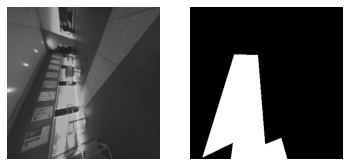

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# PILライブラリで画像を読み込む
img = np.asarray(Image.open('train/image/001.png'))
label = np.asarray(Image.open('train/label/001.png'))

# matplotlibライブラリを使って2つの画像を並べて表示
fig, axes = plt.subplots(1, 2)
axes[0].set_axis_off()
axes[0].imshow(img, cmap='gray')
axes[1].set_axis_off()
axes[1].imshow(label, cmap='gray')
plt.show()

### データセットの準備

ダウンロードしたデータセットを学習できるように準備をします．Chainerにはいくつかの便利なデータセットまわりのクラスが用意されています．`ImageDataset`は，画像ファイルへのファイルパスのリストを渡して初期化してやると，そのパスにある画像を**学習時に**ディスクから読み込み，それを返してくれるようなデータセットクラスです．`TupleDataset`は，複数のデータセットオブジェクトを渡して初期化すると，それらから同じインデックスを持つデータをタプルに束ねて返してくれるようなデータセットオブジェクトを作成するクラスです．（Pythonの`zip`と同様です．）

今回はSemantic Segmentationなので，入力も出力も画像です．なので，2つの`ImageDataset`オブジェクトを作成します．

In [0]:
import glob
from chainer import datasets

def create_dataset(img_filenames, label_filenames):
    img = datasets.ImageDataset(img_filenames)
    img = datasets.TransformDataset(img, lambda x: x / 255.)  # 0-1に正規化
    label = datasets.ImageDataset(label_filenames, dtype=np.int32)
    dataset = datasets.TupleDataset(img, label)
    return dataset

def create_datasets():
    # Python標準のglobを使ってMRI画像ファイル名/ラベル画像ファイル名の一覧を取得
    train_img_filenames = sorted(glob.glob('train/image/*.png'))
    train_label_filenames = sorted(glob.glob('train/label/*.png'))

    # リストを渡して，データセットオブジェクト train を作成
    train = create_dataset(train_img_filenames, train_label_filenames)

    # 同様のことをvalidationデータに対しても行う
    val_img_filenames = sorted(glob.glob('val/image/*.png'))
    val_label_filenames = sorted(glob.glob('val/label/*.png'))
    val = create_dataset(val_img_filenames, val_label_filenames)
    
    return train, val

train, val = create_datasets()
print('Dataset size:\n\ttrain:\t{}\n\tvalid:\t{}'.format(len(train), len(val)))

Dataset size:
	train:	170
	valid:	10


In [0]:
### モデルの定義

次に，訓練するモデルの定義です．ここでは3種類のネットワークを定義します. 使用時にクラス名を指定すれば良い.
1. 全結合型ニューラルネットワーク．
2. Convolution neural network (CNN)
3. SegNet
4. UNet

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L

from chainer import reporter
from chainer import cuda
from chainercv import evaluations

from chainer import Chain
class FullyConvolutionalNetwork(chainer.Chain):

    def __init__(self, out_h, out_w):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(100, 100)
            self.l3 = L.Linear(100, out_h * out_w)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        n = x.shape[0]

        return h.reshape((n, 1, self.out_h, self.out_w))

class CNN(chainer.Chain):

    def __init__(self, out_h, out_w, n_class=1):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # とかくこともできます．
            self.conv1 = L.Convolution2D(None, 64, ksize=6, stride=2, pad=2)
            self.conv2 = L.Convolution2D(None, 128, ksize=4, stride=2, pad=2)
            self.conv3 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.conv5 = L.Convolution2D(None, 128, ksize=1, stride=1, pad=0)
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書くこともできます．
            self.deconv6 = L.Deconvolution2D(None, n_class, ksize=32, stride=15, pad=1)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = self.deconv6(h)

        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])

print('FullyConvolutionalNetwork:',FullyConvolutionalNetwork(360, 360)(np.zeros((1, 1, 360, 360), dtype=np.float32)).shape[2:])

class SegNet(Chain):

    def __init__(self, n_class=1):
        super().__init__()
        with self.init_scope():

            self.enco1_1 = L.Convolution2D(None,  64, ksize=3, stride=1, pad=1) #image size will not change
            self.enco2_1 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.enco3_1 = L.Convolution2D(None, 256, ksize=3, stride=1, pad=1)
            self.enco4_1 = L.Convolution2D(None, 512, ksize=3, stride=1, pad=1)

            self.deco4_1 = L.Convolution2D(None, 512, ksize=3, stride=1, pad=1)
            self.deco3_1 = L.Convolution2D(None, 256, ksize=3, stride=1, pad=1)
            self.deco2_1 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.deco1_1 = L.Convolution2D(None,  64, ksize=3, stride=1, pad=1)
            self.deco0_1 = L.Convolution2D(None, n_class, ksize=1)

            self.bn_enco1_1 = L.BatchNormalization( 64)
            self.bn_enco2_1 = L.BatchNormalization(128)
            self.bn_enco3_1 = L.BatchNormalization(256)
            self.bn_enco4_1 = L.BatchNormalization(512)

            self.bn_deco4_1 = L.BatchNormalization(512)
            self.bn_deco3_1 = L.BatchNormalization(256)
            self.bn_deco2_1 = L.BatchNormalization(128)
            self.bn_deco1_1 = L.BatchNormalization( 64)

    def __call__(self, x): #x = (batchsize, 3, 360, 480)
        
        x = F.local_response_normalization(x) #Needed for preventing from overfitting

        h = F.relu(self.bn_enco1_1(self.enco1_1(x)))
        h, idx1 = F.max_pooling_2d(h, 2, stride=2, return_indices=True)

        h = F.relu(self.bn_enco2_1(self.enco2_1(h)))
        h, idx2 = F.max_pooling_2d(h, 2, stride=2, return_indices=True) 

        h = F.relu(self.bn_enco3_1(self.enco3_1(h)))
        h, idx3 = F.max_pooling_2d(h, 2, stride=2, return_indices=True) 

        h = F.relu(self.bn_enco4_1(self.enco4_1(h)))
        
        #h = F.dropout(h)
        
        h, idx4 = F.max_pooling_2d(h, 2, stride=2, return_indices=True) 

        h = F.relu(self.bn_deco4_1(self.deco4_1(h)))
        h = F.unpooling_2d(h, ksize=2, stride=2, outsize=(idx3.shape[2], idx3.shape[3]))

        h = F.relu(self.bn_deco3_1(self.deco3_1(h)))
        h = F.unpooling_2d(h, ksize=2, stride=2, outsize=(idx2.shape[2], idx2.shape[3]))

        h = F.relu(self.bn_deco2_1(self.deco2_1(h)))
        h = F.unpooling_2d(h, ksize=2, stride=2, outsize=(idx1.shape[2], idx1.shape[3]))

        h = F.relu(self.bn_deco1_1(self.deco1_1(h)))
        h = F.unpooling_2d(h, ksize=2, stride=2, outsize=(x.shape[2], x.shape[3]))

        h = self.deco0_1(h)

        return h
print('SegNet:',SegNet(360, 360)(np.zeros((1, 1, 360, 360), dtype=np.float32)).shape[2:])


FullyConvolutionalNetwork: (360, 360)


TypeError: ignored

### Trainerの定義

次にTrainerを定義しましょう．`Trainer`オブジェクトを作成して返してくれる`create_trainer`関数を定義しましょう．各引数の定義は以下の通りです‥

- ミニバッチサイズ（batchsize）
- 学習用データセット（train）
- 検証用データセット（val）
- 学習を停止するタイミング（stop）
- 使用するデバイス（device）← `-1`にするとCPU，`>=0`の場合はそのIDを持つGPU

以下のセルを実行してください．

In [0]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions

def create_trainer(batchsize, train, val, stop, device=-1, log_trigger=(1, 'epoch')):
    model = FullyConvolutionalNetwork(out_h=360, out_w=360)
    train_model = PixelwiseSigmoidClassifier(model)

    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')

    logging_attributes = [
        'epoch', 'main/loss', 'main/miou', 'main/pa',
        'val/main/loss', 'val/main/miou', 'val/main/pa']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(extensions.PlotReport(['main/pa', 'val/main/pa'], 'epoch', file_name='pa.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer,model

In [0]:
%%time
trainer,model = create_trainer(64, train, val, (50, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()
chainer.serializers.save_hdf5('mymodel_gpu.h5',model)
model.to_cpu()
chainer.serializers.save_hdf5('mymodel_cpu.h5',model)

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.516477    0.467137    0.795419    0.520902       0.479092       0.789696     
20          0.409302    0.562715    0.783279    0.398226       0.62584        0.840106     
30          0.336693    0.569021    0.840894    0.349029       0.572327       0.833311     
40          0.320767    0.599101    0.855419    0.340272       0.599359       0.839254     
50          0.354842    0.671365    0.838989    0.30046        0.622023       0.855883     
CPU times: user 1min 8s, sys: 8.09 s, total: 1min 16s
Wall time: 4min 48s


In [0]:
from IPython.display import Image
Image('result/loss.png')
Image('result/accuracy.png')

In [0]:
from chainer import cuda
from chainercv import evaluations

def evaluate(trainer, val, device=-1):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor
    chainer.serializers.load_hdf5("mymodel_cpu.h5",model)

    # validationデータ全部に対して予測を行う
    preds = []
    for img, label in val:
        img = cuda.to_gpu(img[np.newaxis], device)
        pred = model(img)
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        preds.append((pred, label[0]))
    pred_labels, gt_labels = zip(*preds)

    # 評価をして結果を表示
    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIoU:', evals['miou'])
    
evaluate(trainer, val, device=0)

def show_predicts(trainer, val, device=-1, n_sample=3):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
        img, label = val[i]
        img2 = cuda.to_gpu(img, device)
        pred = model(img2[np.newaxis])
        pred = cuda.to_cpu(pred.data[0, 0] > 0)        
        fig, axes = plt.subplots(1, 3)

        axes[0].set_axis_off()
        axes[0].imshow(pred, cmap='gray')

        axes[1].set_axis_off()
        axes[1].imshow(label[0], cmap='gray')

        axes[2].set_axis_off()
        axes[2].imshow(img[0])

        plt.show()

show_predicts(trainer, val, device=0)

TypeError: ignored